In [36]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sympy.abc import alpha
import numpy as np
from sklearn.preprocessing import LabelEncoder
import os
import seaborn as sns
import shap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
#_________________________________Deep Learning Imports__________________________________
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector

In [37]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Verify your dataset path ---
!ls '/content/drive/MyDrive/ds_Kavya_Bhardwaj/csv_files'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fear_greed_index.csv  historical_data.csv  merged_trader_sentiment.csv


In [38]:
!pip install shap seaborn tensorflow matplotlib scikit-learn sympy


In [39]:
# --- Path inside Google Drive ---
data_path = '/content/drive/MyDrive/ds_Kavya_Bhardwaj/csv_files/merged_trader_sentiment.csv'

new_df = pd.read_csv(data_path)
new_df = new_df.sample(frac=1).reset_index(drop=True)  # shuffle


In [40]:
#____________________________________________________Predicting Direction__________________________________________________#
new_df['Timestamp IST'] = pd.to_datetime(new_df['Timestamp IST'], errors='coerce')

# we are separtaing Timestamp IST has date,hour,month instead of dropping it to annalyse the pattern
new_df['hour'] = new_df['Timestamp IST'].dt.hour
new_df['weekday'] = new_df['Timestamp IST'].dt.weekday
new_df['month'] = new_df['Timestamp IST'].dt.month

# Select features + target
target = new_df['Direction']
features = new_df[['value', 'classification', 'Execution Price', 'Size USD',
                   'Start Position', 'Fee', 'Closed PnL', 'Side', 'Coin',
                   'hour', 'weekday', 'month']]

# our RandomForestClassifier cant make prediction on null values so, we drop the null values from target
new_df = new_df.dropna(subset=['Direction'])

# Label encoder for target
le = LabelEncoder()
target_encoded = le.fit_transform(target)


categorical_cols = ['classification', 'Side', 'Coin']
numeric_cols = ['value', 'Execution Price', 'Size USD', 'Start Position', 'Fee', 'Closed PnL', 'hour', 'weekday', 'month']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

print(f"Model Accuracy: {model.score(X_test,y_test)}")

# Create a new sample as dictionary with same feature names used during training
sample_data = pd.DataFrame([{
    'value':76,
    'classification': 'Extreme Greed',
    'Side': 'BUY',
    'Coin': 'AAVE',
    'Size USD': 7.89,
    'Execution Price': 235.25,
    'Start Position': 200,
    'Timestamp IST': '03-12-2024  14:44:00',
    'Fee':0.649642,
    'Closed PnL':0
}])

sample_data['Timestamp IST'] = pd.to_datetime(sample_data['Timestamp IST'], format='%d-%m-%Y %H:%M:%S')
sample_data['hour'] = sample_data['Timestamp IST'].dt.hour
sample_data['month'] = sample_data['Timestamp IST'].dt.month
sample_data['weekday'] = sample_data['Timestamp IST'].dt.weekday


pred = model.predict(sample_data)
pred_class = le.inverse_transform(pred)
print("Predicted Behavior:", pred_class[0])

/tmp/ipython-input-2414927274.py:2: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  new_df['Timestamp IST'] = pd.to_datetime(new_df['Timestamp IST'], errors='coerce')


Model Accuracy: 0.9992425139069713
Predicted Behavior: Open Long


In [41]:
#________________________________________________Predicting Expected Profit (PnL)---------------------------------------#
feature1 = new_df['Closed PnL']
feature2 = new_df['Fee']
feature3 = new_df['Start Position']
feature4 = new_df['value']
# feature5 = new_df['Closed PnL']
def Expected_PnL_true(feature1,feature2,feature3,feature4):
    # new_df['Expected_PnL'] = ((feature1-feature2)/feature3)*feature4
    # return new_df['Expected_PnL']
    Expected_PnL = ((feature1-feature2)/feature3)*feature4
    return Expected_PnL
print(f"[Random Testing] Expected_PnL for index[65]: {Expected_PnL_true(17.979787,0.047249,5015.448602,76)}")


[Random Testing] Expected_PnL for index[65]: 0.27173499245043203


In [42]:
##____________________________________________________Regression Model for Expected Profit_n_Loss__________________________________________________#
# Compute Expected_PnL
new_df['Expected_PnL'] = Expected_PnL_true(
    new_df['Closed PnL'],
    new_df['Fee'],
    new_df['Start Position'],
    new_df['value']
)

# Drop rows with missing target or invalid values
new_df = new_df.dropna(subset=['Expected_PnL', 'value', 'Fee', 'Start Position', 'Closed PnL'])

# Safe computation of Expected_PnL
new_df['Expected_PnL'] = ((new_df['Closed PnL'] - new_df['Fee']) /
                          new_df['Start Position'].replace(0, np.nan)) * new_df['value']

# REplacement of Nan and infinities which might cause hinderance in our result
new_df['Expected_PnL'] = new_df['Expected_PnL'].replace([np.inf, -np.inf], np.nan)
new_df['Expected_PnL'] = new_df['Expected_PnL'].fillna(new_df['Expected_PnL'].median())

# features influencing Expected_PnL are similar
prof_regression_features = new_df[['value', 'classification', 'Execution Price', 'Size USD',
                                   'Start Position', 'Fee', 'Closed PnL', 'Side', 'Coin',
                                   'hour', 'weekday', 'month']]
prof_regression_target = new_df['Expected_PnL']

# Regression pipeline
prof_regressor = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10, max_features='sqrt', n_jobs=-1)
)
])

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    prof_regression_features, prof_regression_target, test_size=0.2, random_state=42
)

prof_regressor.fit(X_train_r, y_train_r)
y_pred_r = prof_regressor.predict(X_test_r)

print("\nRegression Model Performance:")
print(f"R² Score: {r2_score(y_test_r, y_pred_r)}")
print(f" (Mean Absolute Error): {mean_absolute_error(y_test_r, y_pred_r)}")


Regression Model Performance:
R² Score: -1.0524821837795786
 (Mean Absolute Error): 2209.261473112193


In [43]:
# ------------------ Compare result of function and model ---------------------------
sample_index_in_test_set = 0
sample_data = X_test_r.iloc[[sample_index_in_test_set]]
actual_expected_pnl = y_test_r.iloc[sample_index_in_test_set]
model_predicted_pnl = y_pred_r[sample_index_in_test_set]

print(f"\nComparison for Sample Index (in test set): {sample_index_in_test_set}")

# 'Start Position' != 0
start_position_for_func = sample_data['Start Position'].values[0]
if start_position_for_func == 0:
    print("Warning: 'Start Position' is 0 for this sample. Function calculation might result in inf/NaN.")
    pass

function_calculated_pnl = Expected_PnL_true(
    sample_data['Closed PnL'].values[0],
    sample_data['Fee'].values[0],
    sample_data['Start Position'].values[0],
    sample_data['value'].values[0]
)
# taking the sample first values of all features and calculating model and calculated Expected PnL
print(f"Original 'Closed PnL' for sample: {sample_data['Closed PnL'].values[0]:.4f}")
print(f"Original 'Fee' for sample: {sample_data['Fee'].values[0]:.4f}")
print(f"Original 'Start Position' for sample: {sample_data['Start Position'].values[0]:.4f}")
print(f"Original 'value' for sample: {sample_data['value'].values[0]:.4f}")
print(f"Function Calculated Expected_PnL: {function_calculated_pnl:.4f}")
print(f"Model Predicted Expected_PnL: {model_predicted_pnl:.4f}")
print(f"Actual Expected_PnL (from target): {actual_expected_pnl:.4f}")
print(f"Difference (Function vs. Actual): {abs(function_calculated_pnl - actual_expected_pnl):.4f}")
print(f"Difference (Model vs. Actual): {abs(model_predicted_pnl - actual_expected_pnl):.4f}")



Comparison for Sample Index (in test set): 0
Original 'Closed PnL' for sample: 0.0000
Original 'Fee' for sample: 0.2496
Original 'Start Position' for sample: 4107.6400
Original 'value' for sample: 34.0000
Function Calculated Expected_PnL: -0.0021
Model Predicted Expected_PnL: -731.3043
Actual Expected_PnL (from target): -0.0021
Difference (Function vs. Actual): 0.0000
Difference (Model vs. Actual): 731.3022


In [44]:
# there's a huge difference btw function analysis and model analysis....function's nature is Empirical and it ha  where as model has predictive nature

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


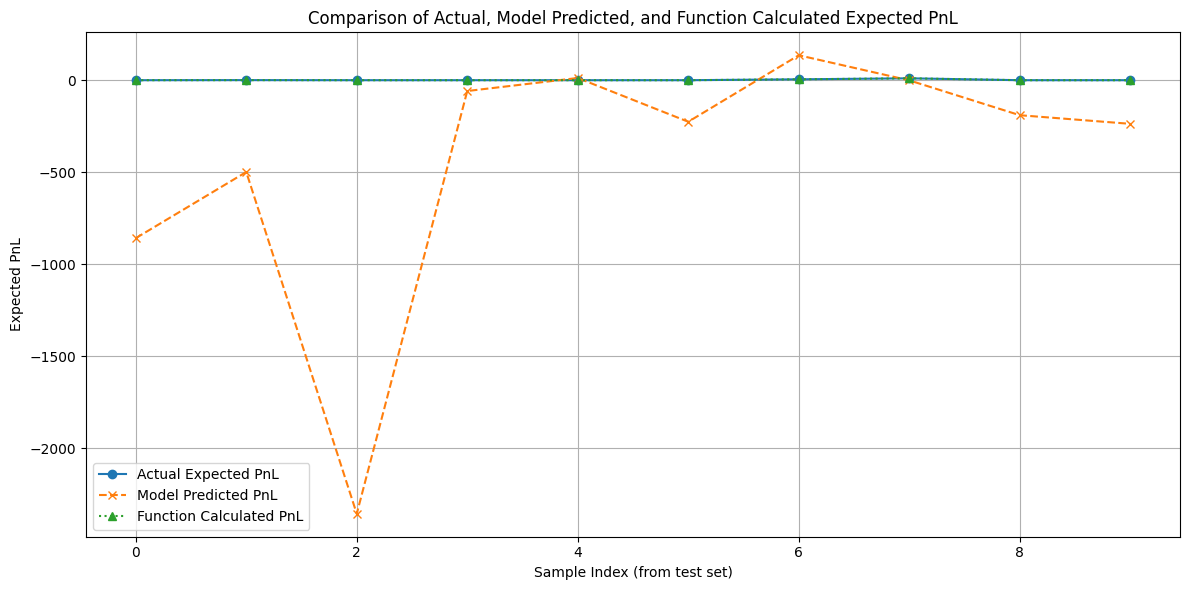

In [45]:
from google.colab import drive
drive.mount('/content/drive')

import os
# ✅ Create folder if it doesn't exist
save_dir = '/content/drive/MyDrive/ds_Kavya_Bhardwaj/outputs'
os.makedirs(save_dir, exist_ok=True)

num_samples_to_plot = 10
num_samples_to_plot = min(num_samples_to_plot, len(y_test_r))

sample_indices = np.random.choice(len(y_test_r), num_samples_to_plot, replace=False)
X_samples_for_plot = X_test_r.iloc[sample_indices]
y_actual_for_plot = y_test_r.iloc[sample_indices]
y_pred_for_plot = y_pred_r[sample_indices]

function_pnl_for_plot = Expected_PnL_true(
    X_samples_for_plot['Closed PnL'].values,
    X_samples_for_plot['Fee'].values,
    X_samples_for_plot['Start Position'].values,
    X_samples_for_plot['value'].values
)

plt.figure(figsize=(12, 6))
plt.plot(np.arange(num_samples_to_plot), y_actual_for_plot, marker='o', linestyle='-', label='Actual Expected PnL')
plt.plot(np.arange(num_samples_to_plot), y_pred_for_plot, marker='x', linestyle='--', label='Model Predicted PnL')
plt.plot(np.arange(num_samples_to_plot), function_pnl_for_plot, marker='^', linestyle=':', label='Function Calculated PnL')
plt.title('Comparison of Actual, Model Predicted, and Function Calculated Expected PnL')
plt.xlabel('Sample Index (from test set)')
plt.ylabel('Expected PnL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'Comparsion_func(Pnl)_Vs_Model.png'), dpi=300)
plt.show()


In [46]:
#--------------------------------OUTCOME: function works better than model--------------------

# Predict Expected PnL for new sample
sample_data_reg = sample_data.copy()
predicted_pnl = prof_regressor.predict(sample_data_reg)
print(f" Predicted Expected PnL for new trade: {predicted_pnl[0]:.6f}")


 Predicted Expected PnL for new trade: -731.304267


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Plot saved successfully


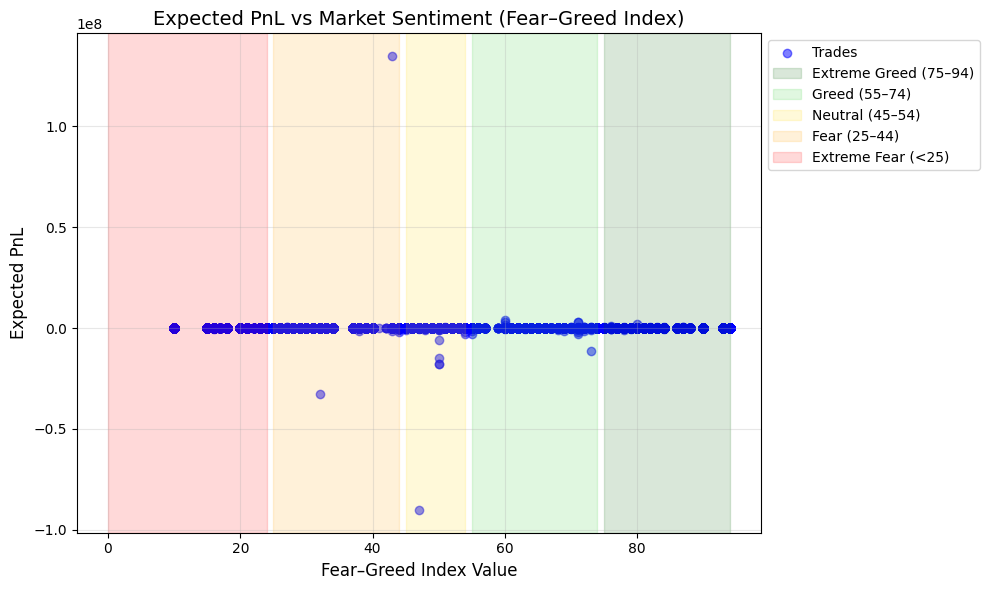

In [47]:
#__________________________________________________Relationship with Expected_PnL__________________________________________
#---------------profit correlate with market sentiment indicators (like “Fear”, “Greed”, “Extreme Greed” etc.).------------
from google.colab import drive
drive.mount('/content/drive')

import os
# ✅ Create folder if it doesn't exist
save_dir = '/content/drive/MyDrive/ds_Kavya_Bhardwaj/outputs'
os.makedirs(save_dir, exist_ok=True)

plt.figure(figsize=(10,6))
plt.scatter(new_df['value'], new_df['Expected_PnL'], alpha=0.5, color='blue', label='Trades')

# Sentiment ranges
plt.axvspan(75, 94, color='darkgreen', alpha=0.15, label='Extreme Greed (75–94)')
plt.axvspan(55, 74, color='limegreen', alpha=0.15, label='Greed (55–74)')
plt.axvspan(45, 54, color='gold', alpha=0.15, label='Neutral (45–54)')
plt.axvspan(25, 44, color='orange', alpha=0.15, label='Fear (25–44)')
plt.axvspan(0, 24, color='red', alpha=0.15, label='Extreme Fear (<25)')

plt.title('Expected PnL vs Market Sentiment (Fear–Greed Index)', fontsize=14)
plt.xlabel('Fear–Greed Index Value', fontsize=12)
plt.ylabel('Expected PnL', fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=0.3)
plt.tight_layout()
# Save plot in same directory
plt.savefig(os.path.join(save_dir, 'Expected_PnL_Vs_Market_sentiment.png'), dpi=300)
print("Plot saved successfully")
plt.show()

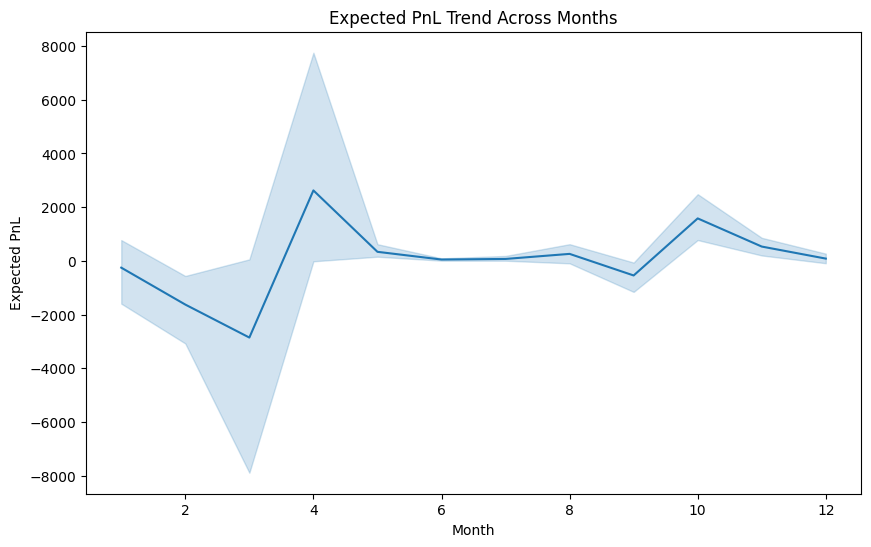

In [48]:
save_dir = '/content/drive/MyDrive/ds_Kavya_Bhardwaj/outputs'
os.makedirs(save_dir, exist_ok=True)
plt.figure(figsize=(10,6))
sns.lineplot(x='month', y='Expected_PnL', data=new_df)
plt.title('Expected PnL Trend Across Months')
plt.xlabel('Month')
plt.ylabel('Expected PnL')
# plt.savefig(".png",dpi=300)
plt.savefig(os.path.join(save_dir, 'PnL_across_month.png'), dpi=300)
plt.show()

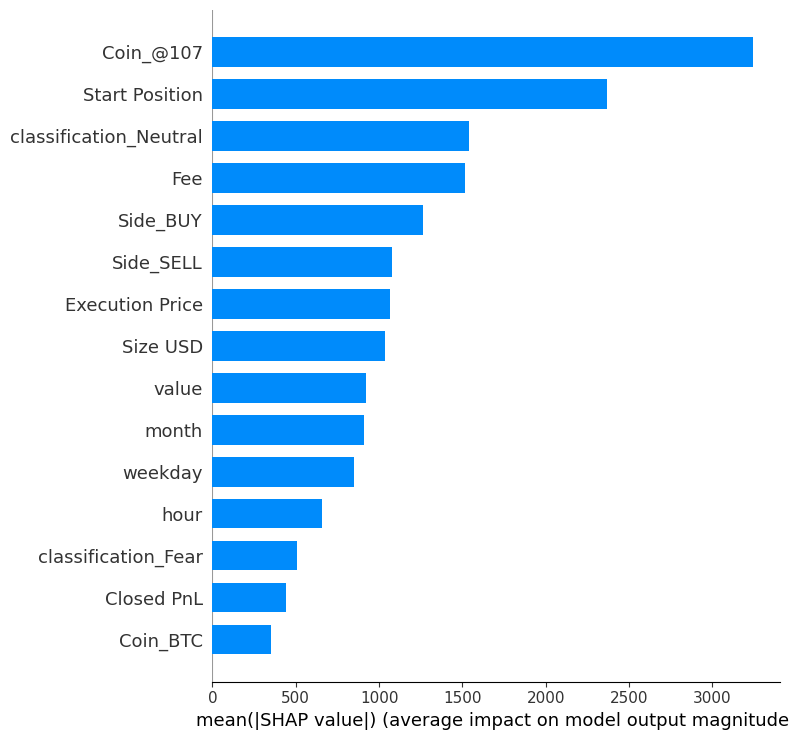

<Figure size 640x480 with 0 Axes>

In [49]:
# moving further to making our model reasonable and explainable for why it took certain steps with SHAP
# -------------------------------------------------SHAP-------------------------------------------------
X_transformed = preprocessor.transform(X_test_r)

# Some transformers return sparse matrices
if not isinstance(X_transformed, np.ndarray):
    X_transformed = X_transformed.toarray()

cat_features = list(
    preprocessor.named_transformers_['cat']
    .named_steps['encoder']
    .get_feature_names_out(categorical_cols)
)
num_features = numeric_cols
all_features = num_features + cat_features

# Ensure features align with transformed array
X_transformed_df = pd.DataFrame(X_transformed, columns=all_features)

explainer = shap.TreeExplainer(prof_regressor.named_steps['regressor'])
shap_values = explainer.shap_values(X_transformed_df)
# SHAP summary plot
# Use the same transformed data for both
shap.summary_plot(shap_values, X_transformed_df, plot_type="bar", max_display=15)
#______________RESULT: Market conditions (Size USD, hour, month) drive PnL more than sentiment or trade type.

save_dir = '/content/drive/MyDrive/ds_Kavya_Bhardwaj/outputs'
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, 'SHAP_Summary_BarPlot.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()



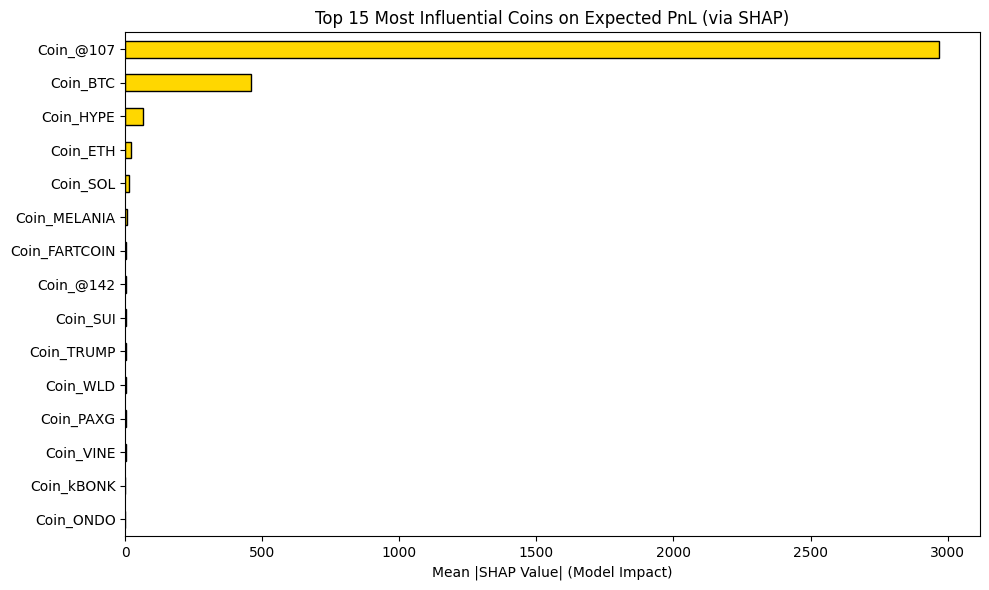

In [51]:
shap_df = pd.DataFrame(shap_values, columns=all_features)
y_series = pd.Series(y_test_r.reset_index(drop=True), name='Expected_PnL')

#================getting the impact of coins on Expected_PnL====================#
#====Which coins tend to have the strongest positive or negative influence on Expected_PnL when all other factors are considered====
# --- True Expected PnL ---
new_df['Expected_PnL_true'] = ((new_df['Closed PnL'] - new_df['Fee']) / new_df['Start Position']) * new_df['value']
new_df['Expected_PnL_true'] = new_df['Expected_PnL_true'].replace([np.inf, -np.inf], np.nan)
new_df['Expected_PnL_true'] = new_df['Expected_PnL_true'].fillna(new_df['Expected_PnL_true'].median())


numeric_cols = ['Execution Price', 'Size USD', 'Size Tokens', 'Closed PnL', 'Fee', 'Start Position', 'value']
categorical_cols = ['Coin', 'Side', 'classification']

preprocessor = ColumnTransformer([
    ('num', 'passthrough', numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

prof_regressor = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        random_state=42,
        n_estimators=50,
        max_depth=6,
        max_features='sqrt',
        n_jobs=-1
    ))
])

prof_regressor.fit(new_df[numeric_cols + categorical_cols], new_df['Expected_PnL_true'])

new_df['Expected_PnL_pred'] = prof_regressor.predict(new_df[numeric_cols + categorical_cols])

# SHAP Analysis...rest working is similar to the above code
explainer = shap.TreeExplainer(prof_regressor.named_steps['regressor'])
X_transformed = preprocessor.transform(new_df[numeric_cols + categorical_cols])

if not isinstance(X_transformed, np.ndarray):
    X_transformed = X_transformed.toarray()

cat_features = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
num_features = numeric_cols
all_features = num_features + cat_features

shap_values = explainer.shap_values(X_transformed)
shap_df = pd.DataFrame(shap_values, columns=all_features)

coin_features = [col for col in shap_df.columns if col.startswith('Coin_')]

coin_importance = shap_df[coin_features].abs().mean().sort_values(ascending=False)

# Top 15 influential coins
top_coins = coin_importance.head(15)

plt.figure(figsize=(10,6))
top_coins.plot(kind='barh', color='gold', edgecolor='black')
plt.title('Top 15 Most Influential Coins on Expected PnL (via SHAP)')
plt.xlabel('Mean |SHAP Value| (Model Impact)')
plt.gca().invert_yaxis()
plt.tight_layout()

save_dir = '/content/drive/MyDrive/ds_Kavya_Bhardwaj/outputs'
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, 'Top_15_coins_VS_Expected_Pnl.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

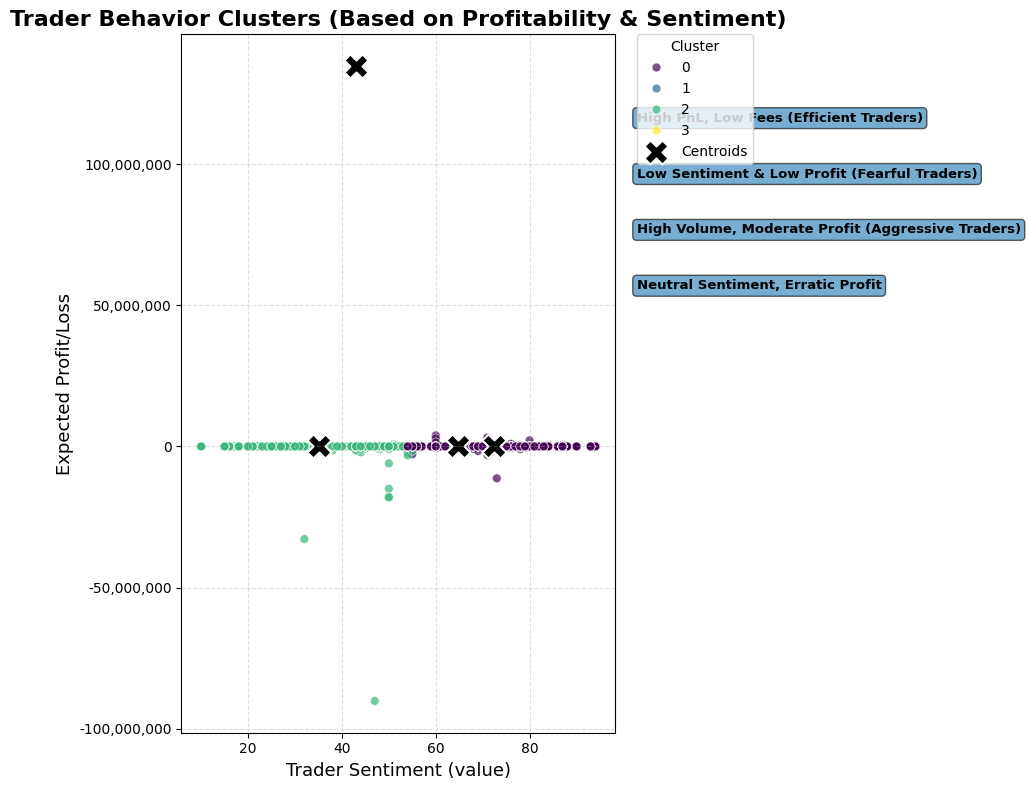

In [52]:
#______________________________Segregating the categories of traders____________________________________#
#_____Features taken for clustering will help in analysing "Behavior + Profitability"___________________#

cluster_feature = new_df[['value', 'Fee', 'Closed PnL', 'Start Position', 'Expected_PnL']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_feature)

kmean_model = KMeans(n_clusters=4, random_state=50, n_init=10)
new_df['Cluster'] = kmean_model.fit_predict(X_scaled)

# --- Cluster_labels ---
cluster_labels = {
    0: 'High PnL, Low Fees (Efficient Traders)',
    1: 'Low Sentiment & Low Profit (Fearful Traders)',
    2: 'High Volume, Moderate Profit (Aggressive Traders)',
    3: 'Neutral Sentiment, Erratic Profit'
}

# --- Plot clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=new_df,
    x='value',
    y='Expected_PnL',
    hue='Cluster',
    palette='viridis',
    s=40,
    alpha=0.7
)

# --- Plottng cluster centroids
centers = kmean_model.cluster_centers_
centers_unscaled = scaler.inverse_transform(centers)
plt.scatter(
    centers_unscaled[:, 0],
    centers_unscaled[:, 4],
    s=300,
    c='black',
    marker='X',
    label='Centroids',
    edgecolors='white',
    linewidth=1.5
)

# --- Title & labels ---
plt.title('Trader Behavior Clusters (Based on Profitability & Sentiment)', fontsize=16, weight='bold')
plt.xlabel('Trader Sentiment (value)', fontsize=13)
plt.ylabel('Expected Profit/Loss', fontsize=13)

# --- Legend outside the plot ---
legend = plt.legend(title='Cluster', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.grid(alpha=0.4, linestyle='--')

# --- Format y-axis numbers ---
plt.ticklabel_format(style='plain', axis='y')
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# --- Add cluster label boxes neatly BELOW the legend ---
for i, label in enumerate(cluster_labels.values()):
    plt.text(
        1.05,
        0.88 - (i * 0.08),
        label,
        transform=plt.gca().transAxes,
        fontsize=9.5,
        weight='bold',
        ha='left',
        va='center',
        bbox=dict(boxstyle="round,pad=0.3", alpha=0.6)
    )

plt.tight_layout(rect=[0, 0, 0.85, 1])
#rectangular layout
save_dir = '/content/drive/MyDrive/ds_Kavya_Bhardwaj/outputs'
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, 'Kmeans_behavior_profitability_clean.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()


 Sequence data shape: (211188, 20, 5)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 20, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 16)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 20, 64)         │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 20, 5)          │         1,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,240 (176.72 KB)

 Trainable params: 45,240 (176.72 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5940/5940 ━━━━━━━━━━━━━━━━━━━━ 235s 37ms/step - loss: 5.4153 - val_loss: 2.1616
Epoch 2/10
5940/5940 ━━━━━━━━━━━━━━━━━━━━ 227s 38ms/step - loss: 0.6957 - val_loss: 2.0548
Epoch 3/10
5940/5940 ━━━━━━━━━━━━━━━━━━━━ 229s 38ms/step - loss: 0.6022 - val_loss: 2.0740
Epoch 4/10
5940/5940 ━━━━━━━━━━━━━━━━━━━━ 263s 39ms/step - loss: 0.5672 - val_loss: 1.9655
Epoch 5/10
5940/5940 ━━━━━━━━━━━━━━━━━━━━ 230s 39ms/step - loss: 0.5493 - val_loss: 1.9437
Epoch 6/10
5940/5940 ━━━━━━━━━━━━━━━━━━━━ 220s 37ms/step - loss: 0.5952 - val_loss: 1.9804
Epoch 7/10
5940/5940 ━━━━━━━━━━━━━━━━━━━━ 262s 37ms/step - loss: 0.5923 - val_loss: 2.0172
Epoch 8/10
5940/5940 ━━━━━━━━━━━━━━━━━━━━ 276s 39ms/step - loss: 0.5904 - val_loss: 1.8303
Epoch 9/10
5940/5940 ━━━━━━━━━━━━━━━━━━━━ 256s 39ms/step - loss: 1.3497 - val_loss: 2.3440
Epoch 10/10
5940/5940 ━━━━━━━━━━━━━━━━━━━━ 252s 37ms/step - loss: 0.6475 - val_loss: 2.1886
6600/6600 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step
 Encoded shape: (211188, 16)


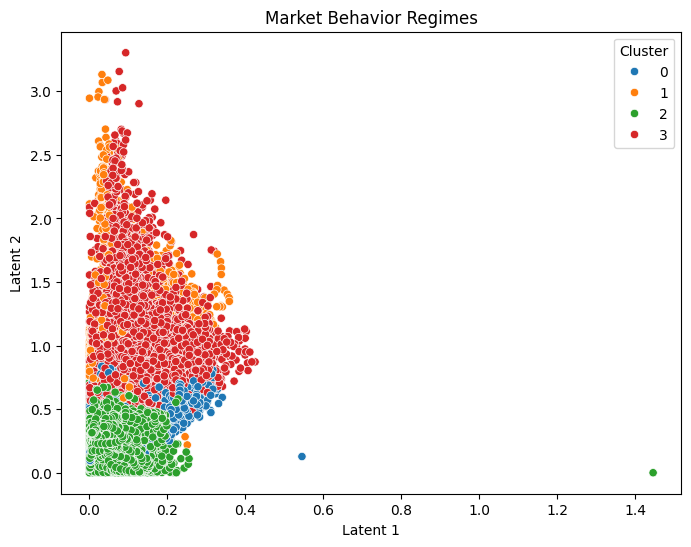

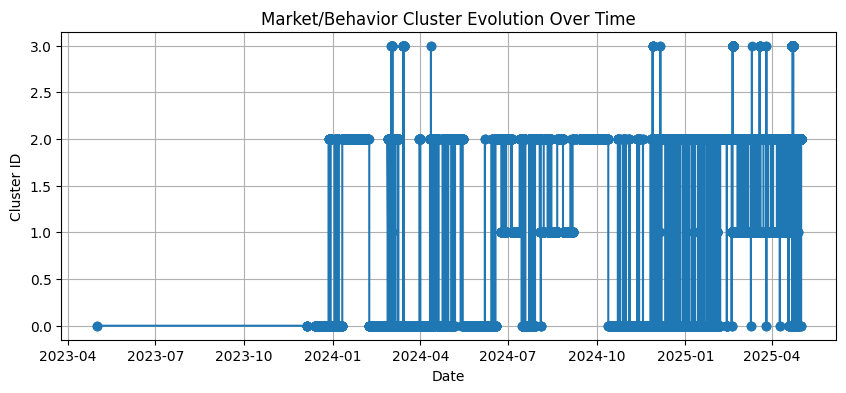

Mean Latent Values per Cluster:
          latent_0  latent_1  latent_2  latent_3  latent_4      latent_5  \
Cluster                                                                   
0        0.078684  0.049684  0.088900  0.000421  0.000026  1.012898e-08   
1        0.044782  0.622519  0.020758  0.001597  0.000013  2.769818e-08   
2        0.053054  0.246532  0.068835  0.002669  0.000051  6.423712e-05   
3        0.148178  0.951527  0.019833  0.020256  0.001239  1.290668e-08   

         latent_6  latent_7  latent_8  latent_9  latent_10  latent_11  \
Cluster                                                                 
0        0.000941  0.001042  0.533329  0.010917   0.001409   0.039832   
1        0.021129  0.045493  0.018648  0.000105   0.000704   0.000005   
2        0.009878  0.023207  0.053573  0.006201   0.026911   0.007428   
3        0.020146  0.009778  1.547404  0.001492   0.001382   0.000217   

         latent_12  latent_13  latent_14  latent_15  Cluster  
Cluster       

In [56]:

#_________________________________________Dynamic personality analysis___________________________________________
new_df['date'] = pd.to_datetime(new_df['date'], errors='coerce').dt.date
new_df = new_df.sort_values(by='date')
#the same features used previously
cluster_feature = ['value', 'Fee', 'Closed PnL', 'Start Position', 'Expected_PnL']
# normalizing using standard scalar
scaler = StandardScaler()
scaled_features = scaler.fit_transform(new_df[cluster_feature])
sequence_length = 20
sequences = []
for i in range(len(scaled_features) - sequence_length + 1):
    seq = scaled_features[i:i+sequence_length]
    sequences.append(seq)

X_seq = np.array(sequences)
print(f" Sequence data shape: {X_seq.shape}")
# (20 timesteps × 5 features) into a 16-dimensional latent vector.
timesteps = X_seq.shape[1]
n_features = X_seq.shape[2]
encoding_dim = 16

inputs = Input(shape=(timesteps, n_features))
encoded = LSTM(64, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(encoding_dim, activation='relu')(encoded)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(n_features, activation='linear', return_sequences=True)(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

history = autoencoder.fit(
    X_seq, X_seq,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)

encoder = Model(inputs, encoded)
X_encoded = encoder.predict(X_seq)
print(f" Encoded shape: {X_encoded.shape}")
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_encoded)

# Attach cluster labels to time segments
encoded_df = pd.DataFrame(X_encoded, columns=[f'latent_{i}' for i in range(X_encoded.shape[1])])
encoded_df['Cluster'] = cluster_labels

encoded_df['Start_Date'] = new_df['date'].iloc[:-sequence_length+1].values

# VISUALIZE CLUSTERS IN LATENT SPACE
# ============================================================
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=encoded_df['latent_0'],
    y=encoded_df['latent_1'],
    hue=encoded_df['Cluster'],
    palette='tab10'
)
plt.title('Market Behavior Regimes')
plt.xlabel('Latent 1')
plt.ylabel('Latent 2')

save_dir = '/content/drive/MyDrive/ds_Kavya_Bhardwaj/outputs'
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, 'cluster_behavior_patterns.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
# plt.savefig('.png', dpi=300, bbox_inches='tight')
plt.show()

# VISUALIZE CLUSTER EVOLUTION OVER TIME
# ============================================================
plt.figure(figsize=(10,4))
plt.plot(encoded_df['Start_Date'], encoded_df['Cluster'], marker='o')
plt.title('Market/Behavior Cluster Evolution Over Time')
plt.xlabel('Date')
plt.ylabel('Cluster ID')
plt.grid(True)

save_dir = '/content/drive/MyDrive/ds_Kavya_Bhardwaj/outputs'
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, 'cluster_evolution_over_time.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
# plt.savefig('.png',dpi=300,bbox_inches='tight')
plt.show()

# INTERPRET CLUSTERS
# Select only numeric columns for aggregation
numeric_cols = encoded_df.select_dtypes(include=['number']).columns
cluster_means = encoded_df.groupby('Cluster')[numeric_cols].mean()
print("Mean Latent Values per Cluster:\n", cluster_means)

   Cluster  mean_expected_pnl  std_expected_pnl  median_expected_pnl   count  \
0        0       6.161447e+01      48254.839791         2.823121e-05   92258   
1        1       1.348114e+08               NaN         1.348114e+08       1   
2        2      -1.649956e+03     293637.303871         0.000000e+00  117819   
3        3       6.991837e-05          0.000692         6.937206e-05    1129   

   pct_negative  
0     44.997724  
1      0.000000  
2     48.689940  
3     13.020372  


/tmp/ipython-input-2459936410.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


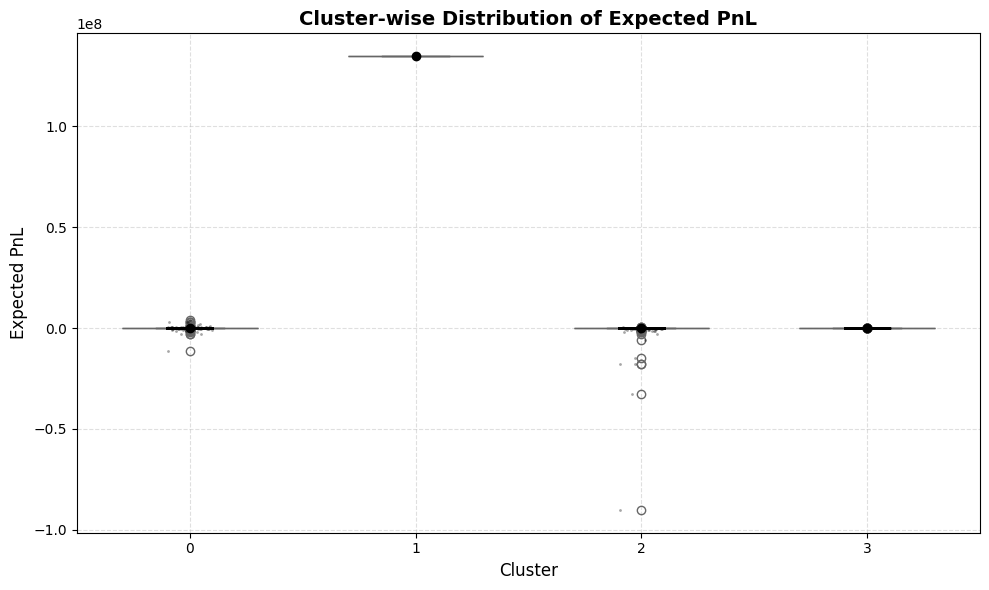

In [58]:
#=============================Risk Factor Analysis grouped by cluster===============================
df = new_df.copy()

# If Expected_PnL does not exist, compute it safely:
if 'Expected_PnL' not in df.columns:
    # avoid division by zero & invalid values
    df['Start Position'] = df['Start Position'].replace(0, np.nan)
    df['Expected_PnL'] = ((df['Closed PnL'] - df['Fee']) / df['Start Position']) * df['value']
    # Replace inf and NaN
    df['Expected_PnL'] = df['Expected_PnL'].replace([np.inf, -np.inf], np.nan)
    df['Expected_PnL'] = df['Expected_PnL'].fillna(df['Expected_PnL'].median())

# Make sure 'Cluster' exists on df. If not, you must run clustering first.
if 'Cluster' not in df.columns:
    raise ValueError("Column 'Cluster' not found in new_df. Run KMeans on trade-level features first.")

# -------------------------------------------------------
# Cluster PnL summary
# -------------------------------------------------------
cluster_pnl_stats = df.groupby('Cluster').agg(
    mean_expected_pnl=('Expected_PnL', 'mean'),
    std_expected_pnl=('Expected_PnL', 'std'),
    median_expected_pnl=('Expected_PnL', 'median'),
    count=('Expected_PnL', 'count'),
    pct_negative=('Expected_PnL', lambda x: (x < 0).mean() * 100)
).reset_index()

print(cluster_pnl_stats)

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x='Cluster',
    y='Expected_PnL',
    palette='coolwarm',
    width=0.6,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"}
)
sns.stripplot(
    data=df,
    x='Cluster',
    y='Expected_PnL',
    color='black',
    size=2,
    alpha=0.35,
    jitter=True
)

plt.title('Cluster-wise Distribution of Expected PnL', fontsize=14, weight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Expected PnL', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

save_dir = '/content/drive/MyDrive/ds_Kavya_Bhardwaj/outputs'
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, 'Cluster_BoxPlot_ExpectedPnL.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
# plt.savefig(".png", dpi=300)
plt.show()